<a href="https://colab.research.google.com/github/AbdullahShareef007/BERT-for-Sentiment-Analysis/blob/main/BERT%20FOR%20SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Libraries import:

- TensorFlow is building and training machine learning models.

- Transformers library from Hugging Face is for pre-trained BERT models.

- InputExample is used to deal with input examples for the model.

- Pandas is used for analyzing and working with data.

- The dataset is split into training and validation sets for model training and evaluation.

- F1 score for evaluating model performance.

- Class weights are used to solve the class imbalance dataset.

- NumPy is used for numerical computations.

In [16]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
import numpy as np



1.   Specifies the file path for the training data in the TSV format, which was uploaded in the Colab using the upload method. Then, it is saved in Colab`s **'/content/'**  

2.   Reads the data from the specified file path into a Pandas DataFrame. Since the file is tsv, it means that the featrues are seperated by commas.


3.   Splits the dataset into training and validation sets for model training and evaluation.

4.  Creates an instance of the pre-trained BERT tokenizer  for  German.






In [17]:
file_path = '/content/train.tsv'
data = pd.read_csv(file_path, sep='\t')
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")



1. Defines a function to convert a list of examples to a TensorFlow dataset for input to BERT.

2. Creates empty lists to save BERT`s input data, including input IDs, attention masks, token type IDs, and labels parameters like max length, padding, and truncation.

3. Iterates through each example in the input list.
4. Uses the BERT`s tokenizer to convert the text of each example into BERT format.


5. Appends the encoded input values (input IDs, attention masks, token type IDs) to their respective lists


6.  Appends the label of each example to the labels list.


7.   Converts the lists of input data to TensorFlow tensors.
8.   Performs one-hot encoding on the labels to prepare them for model training.


9.   Returns a tuple containing the input data tensors and the one-hot encoded labels.







In [18]:


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    labels = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids.append(input_dict["input_ids"])
        attention_masks.append(input_dict["attention_mask"])
        token_type_ids.append(input_dict["token_type_ids"])
        labels.append(e.label)

    return (
        tf.convert_to_tensor(input_ids),
        tf.convert_to_tensor(attention_masks),
        tf.convert_to_tensor(token_type_ids)
    ), tf.one_hot(labels, depth=3)




1.   Computes class weights using scikit-learn's class_weight module,considering the balanced class weights.
2.   Converts the class weights array into a dictionary where the keys are class indices (0, 1, 2) and values are the corresponding class weights.

1.   Uses the convert_examples_to_tf_dataset function to convert the training data to TensorFlow dataset format. It applies this conversion to each example in the training data, using the BERT tokenizer.
2.   Similar to the training data, converts the validation data to TensorFlow dataset format using the same function and BERT tokenizer.

Note: Ensure that the InputExample class has been appropriately defined, and the text_a and label attributes are present in the DataFrame (train_data and val_data).





In [19]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_data['sentiment']), y=train_data['sentiment'])
class_weights_dict = {i: class_weights[i] for i in range(3)}




train_input, train_labels = convert_examples_to_tf_dataset(
    list(train_data.apply(lambda x: InputExample(guid=None, text_a=x['text'], text_b=None, label=x['sentiment']), axis=1)),
    tokenizer
)
val_input, val_labels = convert_examples_to_tf_dataset(
    list(val_data.apply(lambda x: InputExample(guid=None, text_a=x['text'], text_b=None, label=x['sentiment']), axis=1)),
    tokenizer
)





1.   Initializes a BERT model for sequence classification using the German-cased version with three output labels.
2.   Uses the Adam optimizer with a specific learning rate (1e-5) and epsilon value (1e-08).


3.    Configures the model for training. The loss function is set to categorical crossentropy since the task involves multiple classes. The metric for evaluation is accuracy.




In [29]:

model = TFBertForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])




All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-31-fbea5d6e868f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=train_data, palette='viridis')


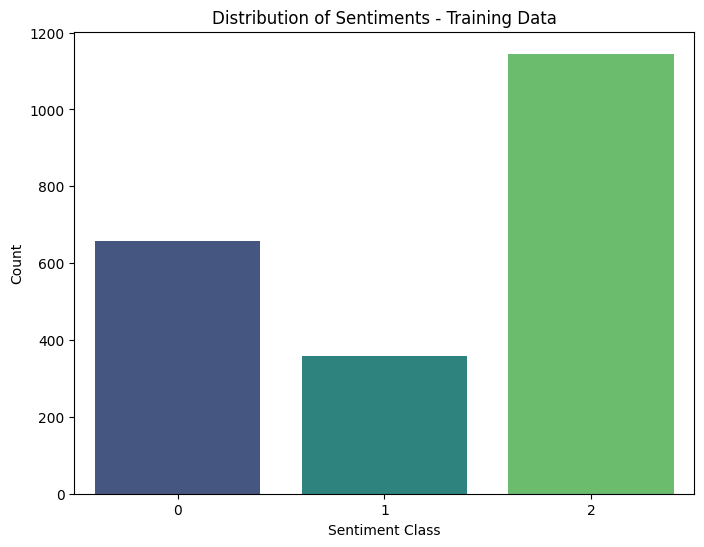

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=train_data, palette='viridis')
plt.title('Distribution of Sentiments - Training Data')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.show()


In [34]:
import random


num_examples_to_display = 5


random_examples = train_data.sample(num_examples_to_display, random_state=42)


for index, row in random_examples.iterrows():
    print(f"Sentiment: {row['sentiment']}")
    print(f"Text: {row['text']}\n")


Sentiment: 2
Text: https://t.co/DxJu9TyvcM Der Untergang dieser Republik ist so gewiss wie das Amen in der Kirche,es herrscht eine warlose Selbstbedienung dieser Staatsvertreter.Bürger mit ihrem Kleingeld werden noch ärmer gemacht.Eine Regierung des Schreckens und der Unverhältnismäßigkeit.

Sentiment: 1
Text: WTF! Mehrere Monate Haft für berechtigten Protest, der niemand physisch schadet. Die Richter*innen hätten auch anders entscheiden können. Die #Klimakatastrophe nehmen die nicht wirklich ernst.\n\n#LetzteGeneration https://t.co/IzKfhpHbvn

Sentiment: 0
Text: Menschenrechtsexperte &amp; auch ein ehemaliger Professor von mir - Manfred Nowak - drängt auf „Kompromisse“ &amp; „Friedensverhandlungen“ bei gleichzeitigem Beistand mit der #ukraine! Eine vernünftige Stimme inmitten voller Unvernunft.  https://t.co/6i5fXrmuoH

Sentiment: 1
Text: Die Erneuerbaren müssen in #Europa deutlich zulegen. Welche Hürden stehen ihrem Ausbau bislang im Weg? Wie lassen sich diese beseitigen? Dazu schrei


  **Fits the  model on the training data. The hyperparameters are:**

1. train_input and train_labels: Training data and corresponding labels.

2. epochs=3: The number of times the model will iterate over the entire training dataset.

3.   batch_size=32: The number of data points used in each iteration

4.   validation_data=(val_input, val_labels): Validation data to evaluate the model's performance on unseen data during training.

5.   class_weight=class_weights_dict: Provides weights for different classes to handle class imbalance.







In [21]:
model.fit(train_input, train_labels, epochs=3, batch_size=32, validation_data=(val_input, val_labels), class_weight=class_weights_dict)

Epoch 1/3
68/68 [==============================] - 98s 860ms/step - loss: 1.0682 - accuracy: 0.3931 - val_loss: 1.0065 - val_accuracy: 0.4852
Epoch 2/3
68/68 [==============================] - 58s 853ms/step - loss: 0.9146 - accuracy: 0.6079 - val_loss: 0.8261 - val_accuracy: 0.6574
Epoch 3/3
68/68 [==============================] - 60s 881ms/step - loss: 0.7350 - accuracy: 0.7097 - val_loss: 0.7692 - val_accuracy: 0.6815




1.   Uses the trained model to make predictions on the validation data.
2.    Input data for validation


1.   Predicted probabilities for each class.
2.    Logits obtained from the predicted probabilities.


1.   Predicted class labels by choosing the one with the highest probability for each example.
2.    Evaluates the model's performance using the F1 score, a metric that considers both precision and recall.







In [22]:
val_pred_probs = model.predict(val_input)
val_logits = val_pred_probs.logits
val_preds = tf.argmax(val_logits, axis=1)

f1 = f1_score(tf.argmax(val_labels, axis=1), val_preds, average='macro')
print(f'Macro F1 Score: {f1}')


17/17 [==============================] - 9s 260ms/step
Macro F1 Score: 0.6364241035557283




1.    saves the model for future use.
2.   Saves the model's architecture, weights, and optimizer state.


1.   Saves the tokenizer configuration and vocabulary.
2.   Combines both model and tokenizer saving into a single call for compatibility.





In [23]:

model.save('/content/sentiment_analysis_model')
tokenizer.save_pretrained('/content/sentiment_analysis_model')
model.save_pretrained('/content/sentiment_analysis_model')



**FOR TESTING THE MODEL ON UNSEEN DATA**

In [24]:
#loading the model
model = TFBertForSequenceClassification.from_pretrained("/content/sentiment_analysis_model")
tokenizer = BertTokenizer.from_pretrained("/content/sentiment_analysis_model")

#opening the test data from colab
file_path = '/content/holdback.tsv'

# reading the data
test_data = pd.read_csv(file_path, sep='\t')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids.append(input_dict["input_ids"])
        attention_masks.append(input_dict["attention_mask"])
        token_type_ids.append(input_dict["token_type_ids"])

    return (
        tf.convert_to_tensor(input_ids),
        tf.convert_to_tensor(attention_masks),
        tf.convert_to_tensor(token_type_ids),
    )

# Converting them to tf dataset
test_input = convert_examples_to_tf_dataset(
    list(test_data.apply(lambda x: InputExample(guid=None, text_a=x['text'], text_b=None, label=None), axis=1)),
    tokenizer
)

# Predicttion
test_pred_probs = model.predict(test_input)
test_logits = test_pred_probs.logits
test_preds = tf.argmax(test_logits, axis=1)

# giving predicted labels
test_data['sentiment'] = test_preds.numpy()

# Saving the results
output_file_path = '/content/test_results.tsv'
test_data[['id', 'sentiment']].to_csv(output_file_path, sep='\t', index=False)

# giving the path to the saved file
print(f'Results saved to {output_file_path}')

Some layers from the model checkpoint at /content/sentiment_analysis_model were not used when initializing TFBertForSequenceClassification: ['dropout_455']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/sentiment_analysis_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


10/10 [==============================] - 5s 239ms/step
Results saved to /content/test_results.tsv
